In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import scipy.special as sp
import sklearn.datasets as datasets
import sklearn.linear_model as lm
import sklearn.ensemble as en
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
import econml
import importlib
import pyreadr

#### data generation packages
import strawman_edge
import strawman_center
import all_linear

#### main packages
import characterize
import estimate_atte as est
import learn_w as learn
import black

importlib.reload(est)
importlib.reload(learn)

import warnings

warnings.filterwarnings("ignore")

%load_ext jupyter_black
sns.set(font_scale=1.25, style="whitegrid")
np.random.seed(0)

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


In [115]:
# baseline_harmonized = pyreadr.read_r(
#     "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/merged/baseline_harmonized_07272023.rds"
# )[None].set_index("who")

# relapse_harmonized_wide = pyreadr.read_r(
#     "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/merged/relapse_harmonized_wide_09062023.rds"
# )[None].set_index("who")
outcome_cols = ["week_12_relapse", "weeks_to_relapse"]

baseline_harmonized = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/oud_optimal_rule_data/optimal_rule_data.csv",
    index_col=0,
)

baseline_harmonized = baseline_harmonized.rename(
    columns={col: col.split(".")[1] for col in baseline_harmonized.columns}
).set_index("who")

stacked_list = []
for i in range(1, 6):
    stacked_list.append(
        pd.read_csv(
            "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/stacked_list_%d.csv"
            % (i),
            index_col=0,
        )
    )
df = stacked_list[0]

df_tedsa = df.loc[df["trialdata"] == 0]

In [113]:
pd.get_dummies(baseline_harmonized, columns=["medicine"]).groupby(by=["project"]).mean()

,sex,age,xrace,site,trt,switched_meds,never_initiated,hwithdraw,alcdisorder,cocdisorder,...,hasMajorDep,bamphetamine30_base,bcannabis30_base,bbenzo30_base,ivdrug,weeks_to_relapse,week_12_relapse,medicine_bup,medicine_met,medicine_nal
project,,,,,,,,,,,,,,,,,,,,,
27,1.321513,36.904649,1.639874,37184.060678,1.583136,0.001576,0.017336,2.472813,0.210402,0.322301,...,0.277384,0.127660,0.286840,0.164697,0.700552,11.797929,0.621749,0.583136,0.416864,0.000000
30,1.419444,32.058333,1.247222,456.755556,3.000000,0.000000,0.000000,2.466667,0.108333,0.077778,...,0.361111,0.072222,0.394444,0.333333,0.022222,14.662698,0.333333,1.000000,0.000000,0.000000
51,1.296491,33.857895,1.678947,2037.208772,4.496491,0.000000,0.168421,2.877193,0.278947,0.307018,...,0.314035,0.189474,0.447368,0.268421,0.701754,14.041353,0.500000,0.503509,0.000000,0.496491


## TEDS-A vs CTN 27

In [129]:
# outcome_cols = ["wk%d.relapse_this_week" % (i) for i in range(1, 11)]
# outcome94 = relapse_harmonized_wide.loc[
#     (relapse_harmonized_wide["project"] == "27")
#     # + (relapse_harmonized_wide["project"] == "30")
#     # + (relapse_harmonized_wide["project"] == "51")
# ][outcome_cols]

ct94 = baseline_harmonized.loc[
    (baseline_harmonized["project"] == 27)
    # + (baseline_harmonized["project"] == 30)
    # + (baseline_harmonized["project"] == 51)
]

outcome94 = ct94[outcome_cols]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

df_tedsa_cc = df_tedsa[common_cols]
df_tedsa_cc["S"] = 0
ct94_cc = ct94[common_cols].fillna(0)
ct94_cc["med_met"] = (
    (ct94["medicine"] == "met").astype(int).fillna(0)
)  # methadone = 1 and bupenorphine = 0
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0

# Create age categories
ct94_cc["age1"] = 0
ct94_cc.loc[ct94_cc["age"] < 15, "age1"] = 1
ct94_cc.loc[(ct94_cc["age"] > 14) & (ct94_cc["age"] < 18), "age1"] = 2
ct94_cc.loc[(ct94_cc["age"] > 17) & (ct94_cc["age"] < 21), "age1"] = 3
ct94_cc.loc[(ct94_cc["age"] > 20) & (ct94_cc["age"] < 25), "age1"] = 4
ct94_cc.loc[(ct94_cc["age"] > 24) & (ct94_cc["age"] < 30), "age1"] = 5
ct94_cc.loc[(ct94_cc["age"] > 29) & (ct94_cc["age"] < 35), "age1"] = 6
ct94_cc.loc[(ct94_cc["age"] > 34) & (ct94_cc["age"] < 40), "age1"] = 7
ct94_cc.loc[(ct94_cc["age"] > 39) & (ct94_cc["age"] < 45), "age1"] = 8
ct94_cc.loc[(ct94_cc["age"] > 44) & (ct94_cc["age"] < 50), "age1"] = 9
ct94_cc.loc[(ct94_cc["age"] > 49) & (ct94_cc["age"] < 55), "age1"] = 10
ct94_cc.loc[(ct94_cc["age"] > 54) & (ct94_cc["age"] < 65), "age1"] = 11
ct94_cc.loc[ct94_cc["age"] > 64, "age1"] = 12

# Assign the 'age1' values to 'age' column
ct94_cc["age"] = ct94_cc["age1"]

# Optionally, you can drop the 'age1' column if you no longer need it
ct94_cc.drop(columns=["age1"], inplace=True)
ct94_cc["S"] = 1
ct94_cc = ct94_cc.astype(int)

ct94_cc = ct94_cc.join(outcome94, how="inner")

# fig, ax = plt.subplots(figsize=(20, 4))
ct94_cc.groupby(by="med_met").mean()[
    outcome_cols
]  # .diff().T[1]#.plot(kind="line", ax=ax)
# plt.axhline(0, c="black")

,week_12_relapse,weeks_to_relapse
med_met,,
0,0.658108,11.079730
1,0.570888,12.802592


In [133]:
df_primary = pd.concat([df_tedsa_cc, ct94_cc])

df_ = df_primary.drop(columns=["weeks_to_relapse"]).fillna(0)

outcome = "week_12_relapse"
treatment = "med_met"
sample = "S"
data = df_
S = df_[sample]  # indicator for the sample
Y = df_[outcome]  # outcome variable
T = df_[treatment]  # indicator for the treatment
X = df_.drop(columns=[outcome, treatment, sample])  # pre-treatment covariates

data_dummy = pd.get_dummies(data, columns=["xrace"])
data_dummy["age"].replace(
    {
        1: 15,
        2: 16,
        3: 18,
        4: 22,
        5: 27,
        6: 32,
        7: 37,
        8: 42,
        9: 47,
        10: 52,
        11: 60,
        12: 65,
    },
    inplace=True,
)
data_dummy

,sex,bamphetamine30_base,bbenzo30_base,ivdrug,bcannabis30_base,age,S,med_met,week_12_relapse,xrace_1,xrace_2,xrace_3,xrace_4
9410,1,1,0,1,0,32,0,0.0,0.0,1,0,0,0
2431,0,0,0,0,0,37,0,0.0,0.0,0,0,0,1
4261,0,1,0,1,1,22,0,0.0,0.0,1,0,0,0
4271,0,1,0,1,0,27,0,0.0,0.0,1,0,0,0
4281,0,1,0,1,0,32,0,0.0,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0605-06-2088,0,0,0,1,0,47,1,0.0,1.0,0,0,0,1
0605-06-2089,0,0,0,1,0,42,1,1.0,1.0,0,0,1,0
0605-06-2090,0,1,1,0,0,27,1,0.0,0.0,1,0,0,0
0605-06-2092,0,0,0,0,1,37,1,1.0,1.0,1,0,0,0


In [134]:
importlib.reload(learn)
df_v, pi, pi_m, mu_1_m, mu_0_m, e_m, data2 = learn.estimate_dml(
    data_dummy, outcome, treatment, sample, crossfit=30
)

print(df_v.join(S).groupby(by="S").mean())

         te     te_sq
S                    
0 -0.057122  0.038800
1 -0.006904  0.590379


In [140]:
importlib.reload(learn)
# D, w_tree, testing_data = learn.tree_opt(data, outcome, treatment, sample, leaf_proba=1)
D_rash, D_forest, w_forest, rashomon_set, f, testing_data = learn.forest_opt(
    data=data_dummy,
    outcome=outcome,
    treatment=treatment,
    sample=sample,
    leaf_proba=0.75,
    num_trees=1000,
    vote_threshold=1 / 2,
    top_k_trees=True,
    k=50,
)

baseline_loss = np.sqrt(np.sum(D_forest["vsq"]) / ((D_forest.shape[0] ** 2)))
optimized_loss_forest = np.sqrt(
    np.sum(D_rash["vsq"] * D_rash["w_opt"]) / ((np.sum(D_rash["w_opt"])) ** 2)
)
print("Baseline Objective:%.4f" % (baseline_loss))
print("Optimized Objective (Forest):%.4f" % (optimized_loss_forest))

ATE Est: -0.0540
leaf                   0.428571
sex                    0.008788
bamphetamine30_base    0.080328
bbenzo30_base          0.080259
ivdrug                 0.051161
bcannabis30_base       0.062923
age                    0.001074
xrace_1                0.143448
xrace_2                0.002816
xrace_3                0.047890
xrace_4                0.092742
dtype: float64
Baseline Objective:0.0003
Optimized Objective (Forest):0.0002


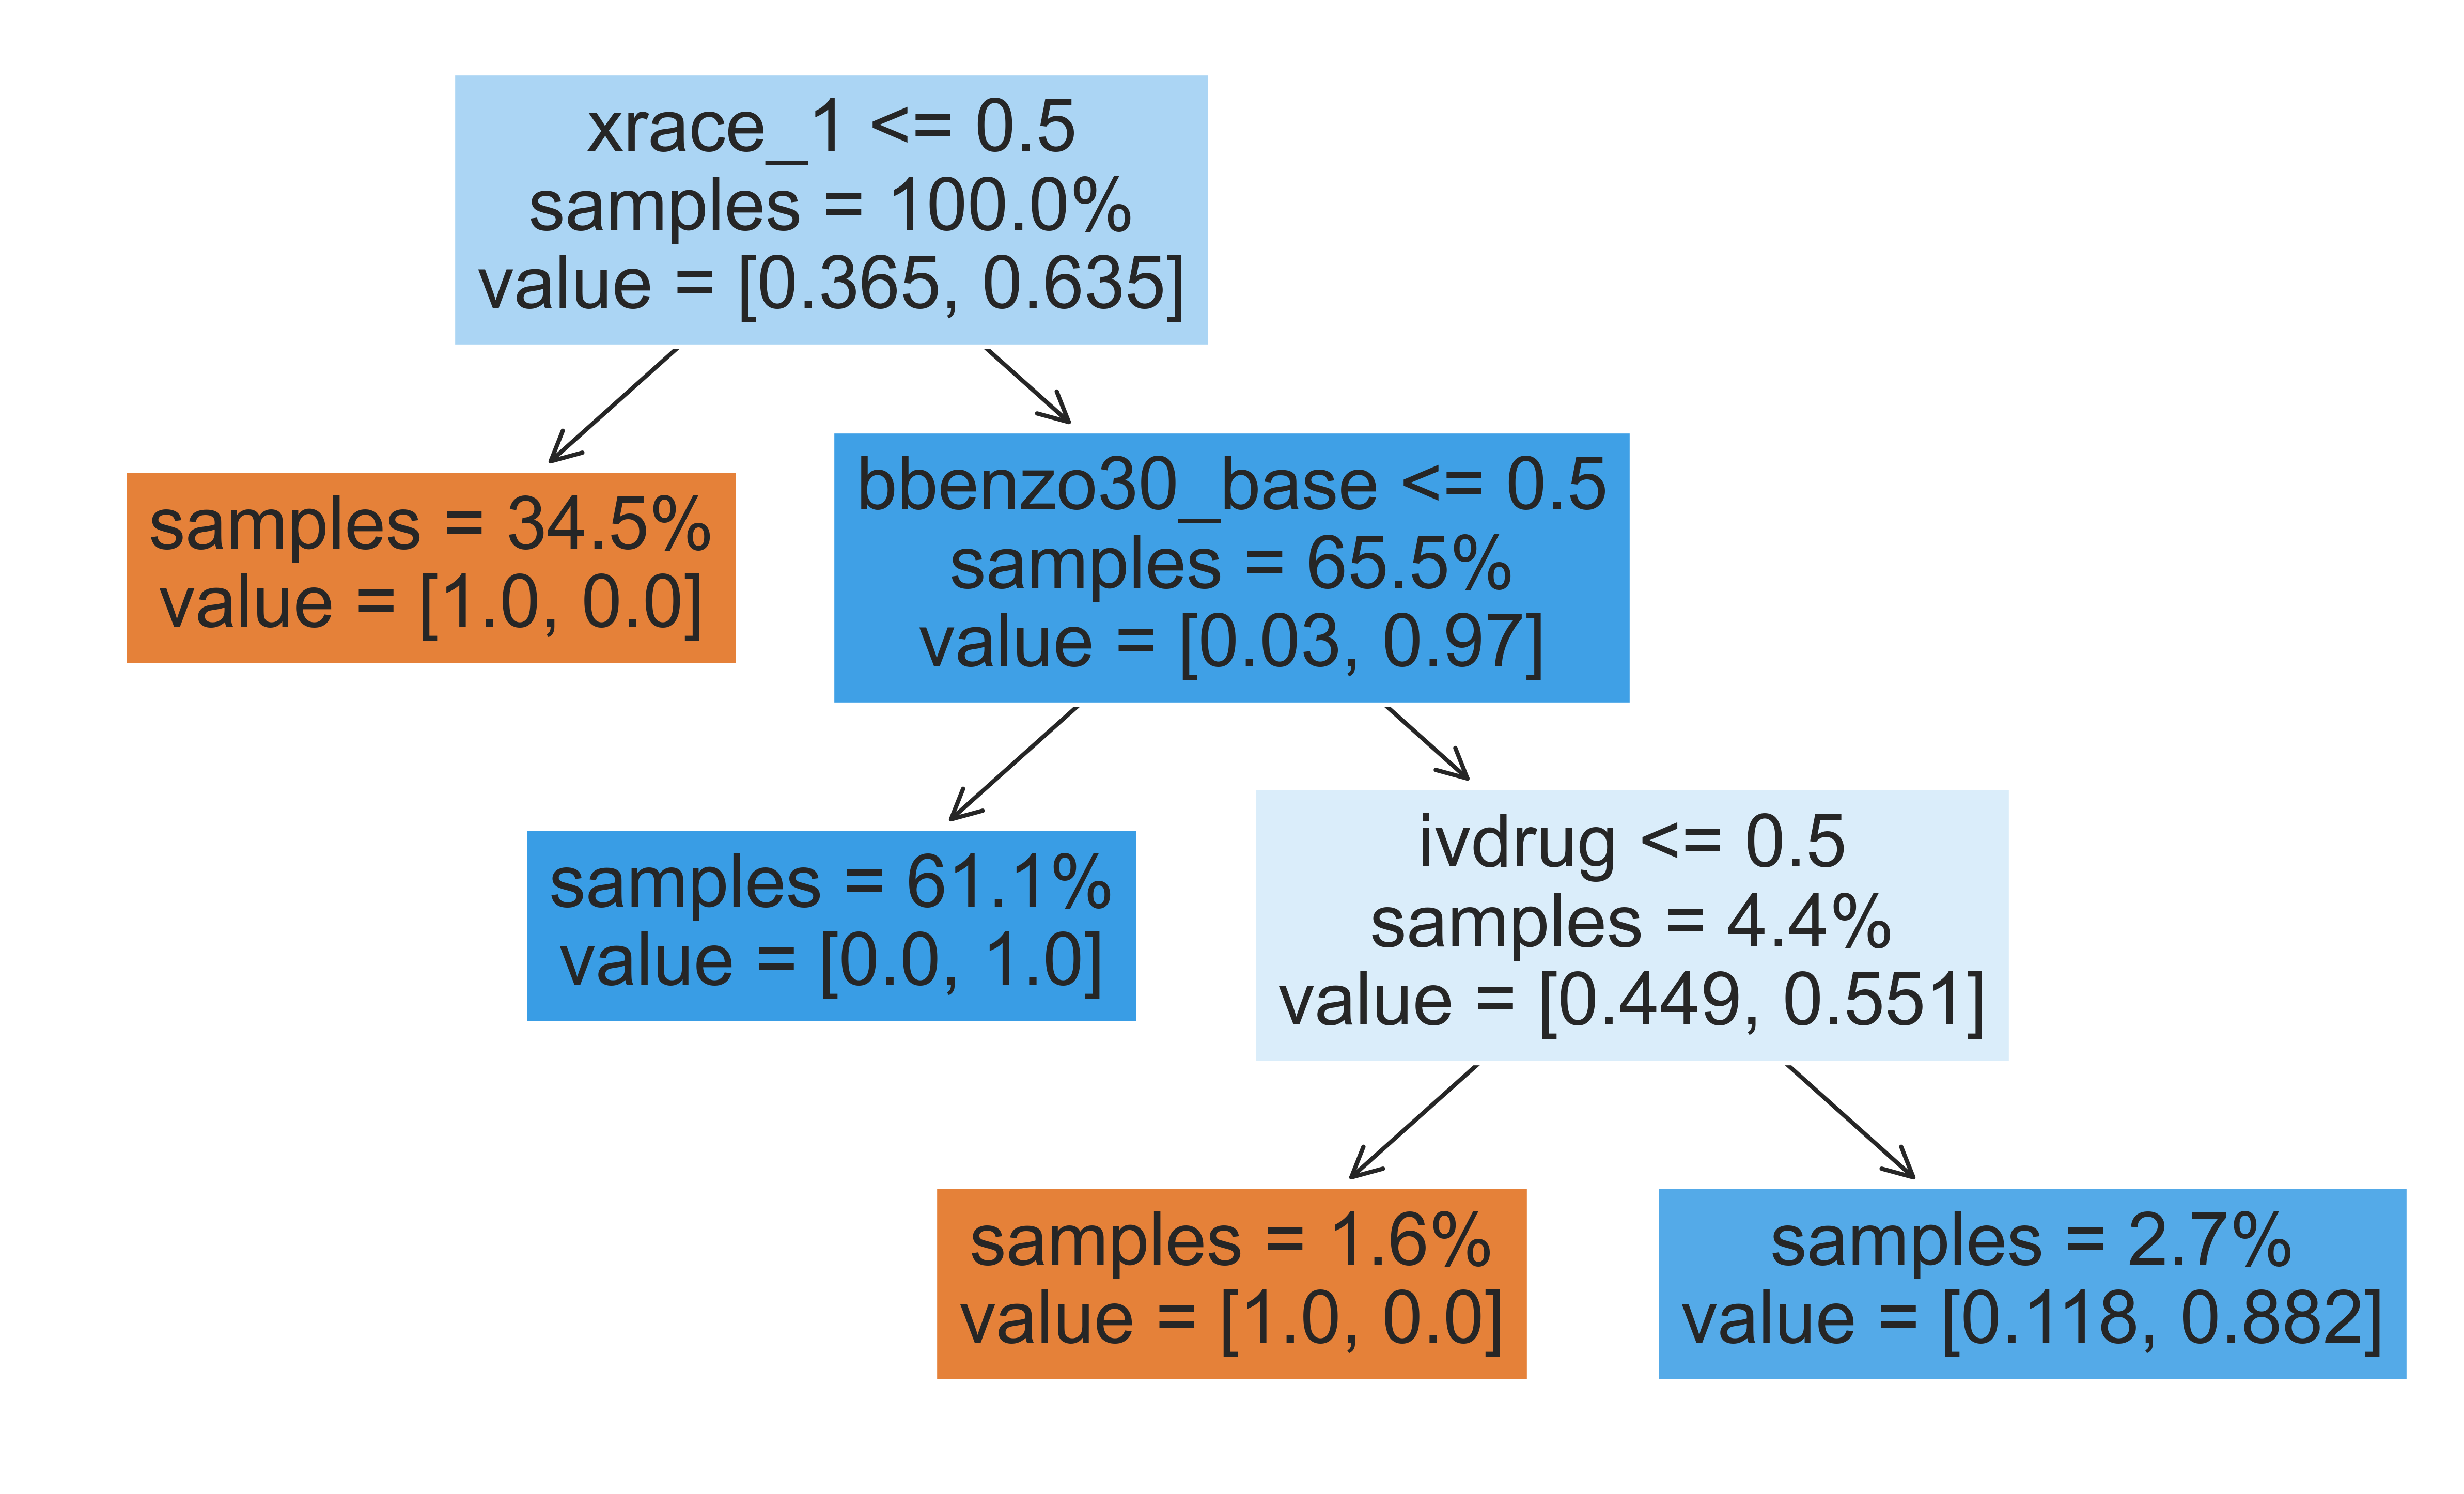

In [141]:
sns.set(font_scale=1)
fig, ax = plt.subplots(ncols=1, figsize=(10, 6), sharex=True, sharey=True, dpi=600)
tree.plot_tree(
    f,
    ax=ax,
    feature_names=data_dummy.drop(columns=[outcome, sample, treatment]).columns,
    filled=True,
    proportion=True,
    impurity=False,
)
plt.savefig("tedsa_ctn27.pdf")

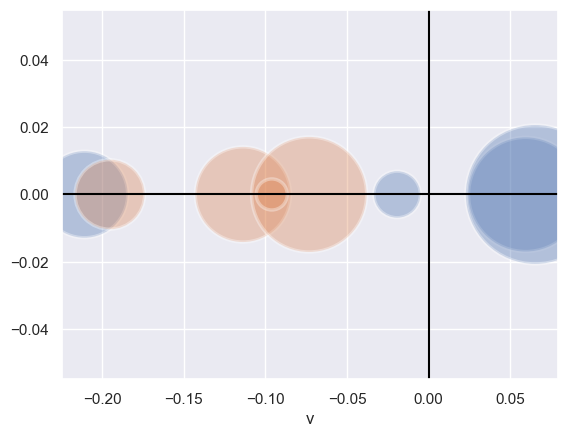

In [183]:
## Looking at the CATEs for the underrepresented subgroups across trial and population
sns.scatterplot(
    x="v",
    y=0,
    size="vsq",
    sizes=(500, 10000),
    alpha=0.35,
    legend=False,
    hue="ivdrug",
    data=D_rash.groupby(by=["xrace_1", "ivdrug", "bbenzo30_base"]).mean()[["v", "vsq"]],
)
plt.axvline(0, c="black")
plt.axhline(0, c="black")

In [159]:
D_rash.to_csv("tedsa_analysis_forest_rashomon_opt.csv")

In [148]:
print(
    r"Pre Pruning, SATE: %.5f ± %.5f"
    % (
        df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].mean()
        - df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].mean(),
        1.96
        * (
            df_.loc[(df_[sample] == 1) * (df_[treatment] == 1), outcome].sem()
            + df_.loc[(df_[sample] == 1) * (df_[treatment] == 0), outcome].sem()
        ),
    )
)

print(
    r"Pre Pruning, ATTE: %.5f ± %.5f"
    % (
        D_rash["v"].mean(),
        1.96 * np.sqrt(D_rash["vsq"].mean() / D_rash["w_opt"].count()),
    )
)

print(
    r"Post Pruning, ATTE: %.5f ± %.5f"
    % (
        D_rash["v"].loc[D_rash["w_opt"] == 1].mean(),
        1.96
        * np.sqrt(
            D_rash["vsq"].loc[D_rash["w_opt"] == 1].mean() / D_rash["w_opt"].sum()
        ),
    )
)

Pre Pruning, SATE: -0.08722 ± 0.07642
Pre Pruning, ATTE: -0.05397 ± 0.00050
Post Pruning, ATTE: -0.06899 ± 0.00046


Thoughts:
* TEDSA (observational data) has fewer covariates than experimental sample. Maybe there is different and interesting question here?

# TEDS-A vs CTN 51

In [74]:
outcome_cols = ["wk%d.relapse_this_week" % (i) for i in range(1, 11)]
outcome94 = relapse_harmonized_wide.loc[
    # (relapse_harmonized_wide["project"] == "27")
    # + (relapse_harmonized_wide["project"] == "30") +
    (relapse_harmonized_wide["project"] == "51")
][outcome_cols]

ct94 = baseline_harmonized.loc[
    # (baseline_harmonized["project"] == "27")
    # + (baseline_harmonized["project"] == "30") +
    (baseline_harmonized["project"] == "51")
]

common_cols = set.intersection(set(df_tedsa.columns), set(ct94.columns))

df_tedsa_cc = df_tedsa[common_cols]
df_tedsa_cc["S"] = 0
ct94_cc = ct94[common_cols].fillna(0)
ct94_cc["med_nal"] = (
    (ct94["medicine"] == "nal").astype(int).fillna(0)
)  # methadone = 1 and bupenorphine = 0
ct94_cc["sex"] = (ct94["sex"] == "male").astype(int)  # male = 1 and female = 0

# Create age categories
ct94_cc["age1"] = 0
ct94_cc.loc[ct94_cc["age"] < 15, "age1"] = 1
ct94_cc.loc[(ct94_cc["age"] > 14) & (ct94_cc["age"] < 18), "age1"] = 2
ct94_cc.loc[(ct94_cc["age"] > 17) & (ct94_cc["age"] < 21), "age1"] = 3
ct94_cc.loc[(ct94_cc["age"] > 20) & (ct94_cc["age"] < 25), "age1"] = 4
ct94_cc.loc[(ct94_cc["age"] > 24) & (ct94_cc["age"] < 30), "age1"] = 5
ct94_cc.loc[(ct94_cc["age"] > 29) & (ct94_cc["age"] < 35), "age1"] = 6
ct94_cc.loc[(ct94_cc["age"] > 34) & (ct94_cc["age"] < 40), "age1"] = 7
ct94_cc.loc[(ct94_cc["age"] > 39) & (ct94_cc["age"] < 45), "age1"] = 8
ct94_cc.loc[(ct94_cc["age"] > 44) & (ct94_cc["age"] < 50), "age1"] = 9
ct94_cc.loc[(ct94_cc["age"] > 49) & (ct94_cc["age"] < 55), "age1"] = 10
ct94_cc.loc[(ct94_cc["age"] > 54) & (ct94_cc["age"] < 65), "age1"] = 11
ct94_cc.loc[ct94_cc["age"] > 64, "age1"] = 12

# Assign the 'age1' values to 'age' column
ct94_cc["age"] = ct94_cc["age1"]

# Optionally, you can drop the 'age1' column if you no longer need it
ct94_cc.drop(columns=["age1"], inplace=True)
ct94_cc["S"] = 1
ct94_cc = ct94_cc.astype(int)

# ct94_cc = ct94_cc.join(outcome94, how="inner")

# fig, ax = plt.subplots(figsize=(20, 4))
# ct94_cc.groupby(by="med_nal").mean()[outcome_cols].diff().T[1].plot(kind="line", ax=ax)
# plt.axhline(0, c="black")

In [106]:
optimal_rules_data = pd.read_csv(
    "/Users/harshparikh/Library/CloudStorage/OneDrive-JohnsHopkins/MOUD_data/oud_optimal_rule_data/optimal_rule_data.csv",
    index_col=0,
)

optimal_rules_data = optimal_rules_data.rename(
    columns={col: col.split(".")[1] for col in optimal_rules_data.columns}
).set_index("who")

In [107]:
optimal_rules_data.groupby(by=["project", "medicine"]).mean()

sex        age     xrace          site  trt  \
project medicine                                                     
27      bup       1.321622  36.994595  1.674324  37101.616216  2.0   
        met       1.321361  36.778828  1.591682  37299.389414  1.0   
30      bup       1.419444  32.058333  1.247222    456.755556  3.0   
51      bup       1.282230  33.675958  1.662021   2037.567944  4.0   
        nal       1.310954  34.042403  1.696113   2036.844523  5.0   

                  switched_meds  never_initiated  hwithdraw  alcdisorder  \
project medicine                                                           
27      bup            0.002703         0.017568   2.485135     0.201351   
        met            0.000000         0.017013   2.455577     0.223062   
30      bup            0.000000         0.000000   2.466667     0.108333   
51      bup            0.000000         0.059233   2.930314     0.306620   
        nal            0.000000         0.279152   2.823322     0.250883   

                  cocdisorder  ...  hasSchiz  hasBipolar  hasAnxPan  \
project medicine               ...                                    
27      bup          0.316216  ...  0.027027    0.113514   0.294595   
        met          0.330813  ...  0.022684    0.119093   0.310019   
30      bup          0.077778  ...  0.002778    0.058333   0.341667   
51      bup          0.348432  ...  0.003484    0.160279   0.432056   
        nal          0.265018  ...  0.021201    0.116608   0.469965   

                  hasMajorDep  bamphetamine30_base  bcannabis30_base  \
project medicine                                                       
27      bup          0.289189             0.122973          0.295946   
        met          0.260870             0.134216          0.274102   
30      bup          0.361111             0.072222          0.394444   
51      bup          0.299652             0.212544          0.463415   
        nal          0.328622             0.166078          0.431095   

                  bbenzo30_base    ivdrug  weeks_to_relapse  week_12_relapse  
project medicine                                                              
27      bup            0.172973  0.700000         11.079730         0.658108  
        met            0.153119  0.701323         12.802592         0.570888  
30      bup            0.333333  0.022222         14.662698         0.333333  
51      bup            0.296167  0.714286         15.357392         0.442509  
        nal            0.240283  0.689046         12.706714         0.558304  

[5 rows x 22 columns]